In [1]:
# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Visualization libraries
# import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
# from sklearn.externals.six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
# from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from joblib import dump, load

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from torch.nn.parallel import DataParallel
from copy import deepcopy
from tqdm import tqdm 
# Seed for reproducability
seed = 1024
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

2024-11-12 13:00:09.559722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 13:00:09.623207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 13:00:09.623624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 13:00:09.726007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 13:00:10.895033: W tensorflow/compiler/tf

In [2]:
def acc(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """
        Calculates the accuracy score between labels and predictions.
        
        :param y_true: The true labels of the data
        :param y_pred: The predictions for the data
        
        :return: a floating point number denoting the accuracy
    """
    return np.round(accuracy_score(y_true, y_pred) * 100, 2)

In [3]:
def produce_soft_labels(data, round_num, fold_num, k=1,model='rf'):

    soft_label = np.zeros([data.shape[0], len(np.unique(data[:, -1]))])

    for i in range(round_num):
        kf = KFold(n_splits=fold_num)
        for train_index, test_index in kf.split(X=data[:, :-1], y=data[:, -1], groups=data[:, -1]):
            train_set, test_set = data[train_index], data[test_index]
            train_X,train_Y=train_set[:, :-1],train_set[:, -1].astype(int)
            test_X=test_set[:, :-1]
            if model=='rf':
                clf = RandomForestClassifier(300, min_samples_leaf=5, criterion="gini")
            clf.fit(train_X, train_Y)

            pred_prob = clf.predict_proba(test_X)
            soft_label[test_index] += pred_prob

    soft_label /= round_num

    hard_label = np.zeros([data.shape[0], len(np.unique(data[:, -1]))])
    for i in range(np.shape(data)[0]):
        hard_label[i][int(data[i, -1])] = 1

    soft_label = (soft_label + hard_label*k) / (k+1)

    return soft_label

X_train.shape before resize and reshape:  (60000, 28, 28)


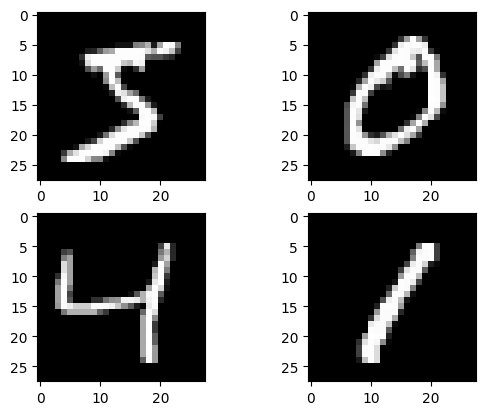

In [3]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
#
print('X_train.shape before resize and reshape: ' , X_train.shape)

plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [5]:
# data_train = np.concatenate((X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]).astype('float32'), y_train.reshape(len(y_train),1).astype('float32')),1)
# soft_label = produce_soft_labels(data_train, round_num=1, fold_num=2, k=1, model='rf')

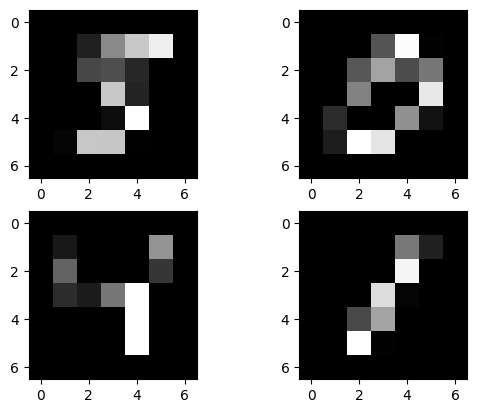

In [4]:
# [X_train_resize.append(cv2.resize(X_train[i], [7,7])) for i in range(X_train.shape[0])]
X_train_resize = np.array([cv2.resize(X_train[i], [7,7],cv2.INTER_AREA) for i in range(X_train.shape[0])])
X_test_resize = np.array([cv2.resize(X_test[i], [7,7],cv2.INTER_AREA) for i in range(X_test.shape[0])])
plt.subplot(221)
plt.imshow(X_train_resize[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_resize[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_resize[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_resize[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [5]:
X_train_resize, X_test_resize = X_train,X_test

num_pixels = X_train_resize.shape[1] * X_train_resize.shape[2]

X_train_resize = X_train_resize.reshape(X_train_resize.shape[0], num_pixels).astype('float32')
X_test_resize = X_test_resize.reshape(X_test_resize.shape[0], num_pixels).astype('float32')


print('X_train.shape after resize and reshape: ' , X_train_resize.shape)

# normalize inputs from 0-255 to 0-1
X_train_resize = X_train_resize / 255
X_test_resize = X_test_resize / 255

# one hot encode outputs
# y_train = np_utils.to_categorical(y_train)
# Y_train = np_utils.to_categorical(y_train)
# Y_test = np_utils.to_categorical(y_test)

# num_classes = Y_test.shape[1]

X_train.shape after resize and reshape:  (60000, 784)


In [6]:
best_depth = 16

In [8]:
clf = DecisionTreeClassifier(max_depth=best_depth,random_state=seed)
clf.fit(X_train_resize, y_train)

DecisionTreeClassifier(max_depth=16, random_state=1024)

In [7]:
clf_rf = load('./srf_model/'+str(best_depth)+'_rf.joblib') 

In [9]:
# Train baseline decision tree model


# Train baseline decision tree model
clf_rf = RandomForestClassifier(50, min_samples_leaf=3, criterion="gini",random_state=108,max_depth=best_depth)
clf_rf.fit(X_train_resize, y_train)




RandomForestClassifier(max_depth=16, min_samples_leaf=3, n_estimators=50,
                       random_state=108)

In [10]:
clf.tree_.max_depth

16

In [8]:
rf_preds_baseline = clf_rf.predict(X_test_resize)
acc(rf_preds_baseline, y_test)

96.47

In [12]:
# Evaluate the baseline model
rf_preds_baseline = clf_rf.predict(X_test_resize)
train_preds_baseline = clf.predict(X_train_resize)
val_preds_baseline = clf.predict(X_test_resize)
acc_baseline_train = acc(train_preds_baseline, y_train)
acc_baseline_val = acc(val_preds_baseline, y_test)
acc_baseline_rf = acc(rf_preds_baseline, y_test)
print(f'Training accuracy for our baseline (using all pixel features): {acc_baseline_train}%')
print(f'Validation accuracy for our baseline (using all pixel features): {acc_baseline_val}%')
print(f'Validation accuracy for our teacher rf model (using all pixel features): {acc_baseline_rf}%')

Training accuracy for our baseline (using all pixel features): 98.83%
Validation accuracy for our baseline (using all pixel features): 88.11%
Validation accuracy for our teacher rf model (using all pixel features): 96.47%


In [13]:
clf_rf.estimators_[0].tree_.max_depth

16

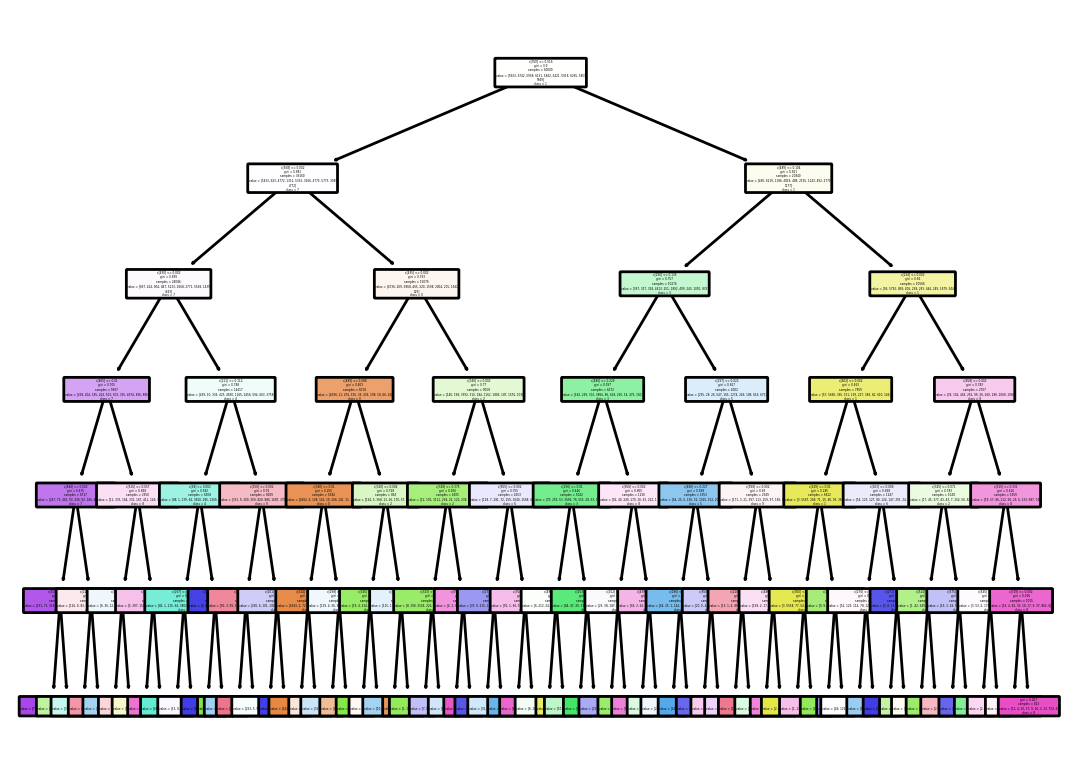

In [18]:
fig = plt.figure(dpi=200)
_ = plot_tree(clf,class_names=['0', '1','2','3','4','5','6','7','8','9'],rounded=True,filled=True)

In [14]:
def tree_path(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    # threshold = clf.tree_.threshold
    max_depth = clf.tree_.max_depth

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)



    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    node_path = np.zeros(shape=[n_nodes,max_depth+1], dtype=np.int64)
    left_right = np.zeros(shape=[n_nodes,max_depth+1], dtype=np.int64)

    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    depth = 0
    for i in range(n_nodes):
        previous_depth = depth
        depth = node_depth[i]
        
        if i!=0:
            node_path[i, :depth] = node_path[i-1, :depth]
            left_right[i, :depth] = left_right[i-1, :depth]
        node_path[i, depth] = i
        if depth>previous_depth:
            left_right[i, depth] = 0
        else:
            left_right[i, depth] = 1

        
    node_path_left_right = np.concatenate((node_path[:,:-1,np.newaxis],left_right[:,1:,np.newaxis]),axis = 2) 
    node_path_left_right = node_path_left_right[feature==-2]
    node_path = node_path_left_right[:,:,0]
    return node_depth, node_path_left_right

In [15]:
node_depth_forest = []
node_path_forest = []
forest_index = []
forest_threshold = []
forest_leaf_value = []
node_accu = 0
for i in range(50):
    node_depth_temp,node_path_temp = tree_path(clf_rf.estimators_[i])
    node_path_temp[:,:,0] = node_path_temp[:,:,0] + node_accu
    node_depth_forest.extend(node_depth_temp)
    node_path_forest.extend(node_path_temp) 
    forest_index.extend(clf_rf.estimators_[i].tree_.feature)
    forest_threshold.extend(clf_rf.estimators_[i].tree_.threshold)
    forest_leaf_value.extend(clf_rf.estimators_[i].tree_.value)
    node_accu = node_accu + len(node_depth_temp)

In [16]:
leaf_index = np.array(forest_index)==-2
forest_node_path = np.array(node_path_forest)[:,:,0]
forest_leaf_depth = np.array(node_depth_forest)[leaf_index]


In [19]:
class SDT(nn.Module):

    def __init__(self, clf,node_depth,node_path_left_right, args):
        super(SDT, self).__init__()
        self.args = args
        self.clf = clf
        self.device = torch.device("cuda" if self.args['use_cuda'] else "cpu")
        self.leaf_num = clf.tree_.n_leaves
        self.leaf_index = clf.tree_.feature==-2
        self.node_depth = node_depth
        self.leaf_depth = node_depth[self.leaf_index]
        self.node_path = node_path_left_right[:,:,0]
        self.node_path_left_right = node_path_left_right

        self.node_gain = nn.Parameter(data=torch.ones(node_path_left_right[:,:,0].shape)*(-10),requires_grad=False)
        self.node_threshold = nn.Parameter(torch.tensor(clf.tree_.threshold[self.node_path],dtype=torch.float),requires_grad=True)
        self.register_parameter('node_gain',self.node_gain)
        self.register_parameter('node_threshold',self.node_threshold)

        self.leaf_nodes = nn.Parameter(data = torch.tensor(clf.tree_.value[self.leaf_index,0,:]), requires_grad = True)
        self.register_parameter('leaf_node',self.leaf_nodes)
        
        self.dropout = nn.Dropout(0.25)


    def forward(self, X, is_training_data=False):

        _mu = self._forward(X)

        if is_training_data:
            output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(output,dim=1)
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)  
            return torch.log(output+1e-18)
        else:
            # output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device),dim=1))  
            output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)
            # print(output.shape)
            return torch.log(output+1e-18)


    def _forward(self, X):
        """Implementation on the data forwarding process."""
        
        batch_size = X.size()[0]
        X = X[:,self.clf.tree_.feature[self.node_path]]
        gain = self.node_gain.to(self.device)
        # print(X.shape)
        # print(self.node_threshold.shape)
        X = (X  - self.node_threshold.to(self.device)) * gain
        X = self.dropout(X)
        path_prob = torch.sigmoid(X)
        path_prob = torch.unsqueeze(path_prob, dim=3)
        path_prob = torch.cat((path_prob, 1 - path_prob), dim=3)
        _mu = X.data.new(batch_size, self.leaf_num).fill_(1.0)

        for layer_idx in range(1, self.args['depth']+1):
            select_leaf = self.leaf_depth==layer_idx
            if sum(select_leaf) > 0:
                mu_temp = path_prob[:,select_leaf,:layer_idx,:]
                mu_temp_index = torch.argwhere(mu_temp[0,:,:,0])
                mu_temp = mu_temp[:,mu_temp_index[:,0].reshape(mu_temp[0,:,:,0].shape),mu_temp_index[:,1].reshape(mu_temp[0,:,:,0].shape),node_path_left_right[select_leaf,:layer_idx,1]]
                _mu[:,select_leaf] = torch.prod(mu_temp,-1)


        return _mu

    def _validate_parameters(self):

        if not self.depth > 0:
            msg = ("The tree depth should be strictly positive, but got {}"
                   "instead.")
            raise ValueError(msg.format(self.depth))

        if not self.lamda >= 0:
            msg = (
                "The coefficient of the regularization term should not be"
                " negative, but got {} instead."
            )
            raise ValueError(msg.format(self.lamda))

In [20]:
class SRF(nn.Module):

    def __init__(self, forest, args):
        super(SRF, self).__init__()
        self.args = args
        self.forest = forest
        self.device = torch.device("cuda:0" if self.args['use_cuda'] else "cpu")
        

        node_depth_forest = []
        node_path_forest = []
        forest_index = []
        forest_threshold = []
        forest_leaf_value = []
        node_accu = 0
        for i in range(50):
            node_depth_temp,node_path_temp = tree_path(self.forest.estimators_[i])
            node_path_temp[:,:,0] = node_path_temp[:,:,0] + node_accu
            node_depth_forest.extend(node_depth_temp)
            node_path_forest.extend(node_path_temp) 
            forest_index.extend(self.forest.estimators_[i].tree_.feature)
            forest_threshold.extend(self.forest.estimators_[i].tree_.threshold)
            forest_leaf_value.extend(self.forest.estimators_[i].tree_.value)
            node_accu = node_accu + len(node_depth_temp)
        self.feature_index = np.array(forest_index)
        self.leaf_index = self.feature_index==-2
        forest_node_path = np.array(node_path_forest)[:,:,0]
        forest_leaf_depth = np.array(node_depth_forest)[self.leaf_index]

        
        

        self.node_depth = np.array(node_depth_forest)
        self.leaf_depth = forest_leaf_depth
        self.node_path = forest_node_path
        self.node_path_left_right = np.array(node_path_forest)
        self.leaf_num = self.node_path_left_right.shape[0]



        self.node_gain = nn.Parameter(data=torch.ones(forest_node_path.shape)*(-10),requires_grad=False)

        self.node_threshold = nn.Parameter(torch.tensor(np.array(forest_threshold)[forest_node_path],dtype=torch.float),requires_grad=True)

        

        self.register_parameter('node_gain',self.node_gain)
        self.register_parameter('node_threshold',self.node_threshold)

        self.leaf_nodes = nn.Parameter(data = torch.tensor(np.array(forest_leaf_value)[self.leaf_index,0,:]), requires_grad = True)
        self.register_parameter('leaf_node',self.leaf_nodes)
        
        self.dropout = nn.Dropout(0.25)


    def forward(self, X, is_training_data=False):

        _mu = self._forward(X)

        if is_training_data:
            output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(output,dim=1)
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)  
            return torch.log(output+1e-18)
        else:
            # output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device),dim=1))  
            output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)
            # print(output.shape)
            return torch.log(output+1e-18)


    def _forward(self, X):
        """Implementation on the data forwarding process."""
        
        batch_size = X.size()[0]
        # X = X[:,self.clf.tree_.feature[self.node_path]]
        X = X[:,self.feature_index[self.node_path] ]
        gain = self.node_gain.to(self.device)
        # print(X.shape)
        # print(self.node_threshold.shape)
        X = (X  - self.node_threshold.to(self.device)) * gain
        X = self.dropout(X)
        path_prob = torch.sigmoid(X)
        path_prob = torch.unsqueeze(path_prob, dim=3)
        path_prob = torch.cat((path_prob, 1 - path_prob), dim=3)
        _mu = X.data.new(batch_size, self.leaf_num).fill_(1.0)

        for layer_idx in range(1, self.args['depth']+1):
            select_leaf = self.leaf_depth==layer_idx
            if sum(select_leaf) > 0:
                mu_temp = path_prob[:,select_leaf,:layer_idx,:]
                mu_temp_index = torch.argwhere(mu_temp[0,:,:,0])
                mu_temp = mu_temp[:,mu_temp_index[:,0].reshape(mu_temp[0,:,:,0].shape),mu_temp_index[:,1].reshape(mu_temp[0,:,:,0].shape),self.node_path_left_right[select_leaf,:layer_idx,1]]
                _mu[:,select_leaf] = torch.prod(mu_temp,-1)


        return _mu

    def _validate_parameters(self):

        if not self.depth > 0:
            msg = ("The tree depth should be strictly positive, but got {}"
                   "instead.")
            raise ValueError(msg.format(self.depth))

        if not self.lamda >= 0:
            msg = (
                "The coefficient of the regularization term should not be"
                " negative, but got {} instead."
            )
            raise ValueError(msg.format(self.lamda))

In [21]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [22]:
y_train.shape

(60000, 10)

In [23]:
class Mnist_dataset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test, train_flag = 1):
        if train_flag:
            self.X_data = X_train
            self.y_data = y_train
        else:
            self.X_data = X_test
            self.y_data = y_test

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        Y = self.y_data[idx,:]
        X = self.X_data[idx,:]
        return X, Y

In [20]:
device_ids = list(range(torch.cuda.device_count()))  


In [21]:
device_ids

[0, 1, 2, 3]

In [26]:
# Parameters
args = {}
# args['input_dim'] = 7 * 7    # the number of input dimensions
args['output_dim'] = 10        # the number of outputs (i.e., # classes on MNIST)
args['input_dim'] = num_pixels    # the number of input dimensions
args['depth'] = best_depth            # tree depth
args['lamda'] = 1e-4           # coefficient of the regularization term
args['lr'] = 1e-3              # learning rate 1e-3
args['weight_decaly'] = 0      # weight decay 5e-5
args['batch_size'] = 100       # batch size
args['epochs'] = 500            # the number of training epochs
args['log_interval'] = 100     # the number of batches to wait before printing logs
args['use_cuda'] = True       # whether to use GPU
# node_depth,node_path_left_right = tree_path(clf)
# tree = SDT(clf,node_depth,node_path_left_right,args)
tree = SRF(clf_rf,args)
# tree = DataParallel(tree, device_ids=device_ids).to(device_ids[0])
# optimizer = torch.optim.SGD(tree.parameters(), lr=args['lr'], momentum=0.9)
optimizer = torch.optim.Adam(tree.parameters(), lr=args['lr'],weight_decay=args['weight_decaly'])

    

train_loader = torch.utils.data.DataLoader(
        Mnist_dataset(X_train = X_train_resize,
                        X_test = X_test_resize,
                        y_train = y_train,
                        y_test = y_test,
                        train_flag=1),
        batch_size=args['batch_size'],
        shuffle=True,
    )
test_loader = torch.utils.data.DataLoader(
        Mnist_dataset(X_train_resize,
                        X_test_resize,
                        y_train,
                        y_test,
                        train_flag=0),
        batch_size=100,
        shuffle=False,
    )
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if args['use_cuda'] else "cpu")

best_testing_acc = 94
testing_acc_list = []
training_loss_list = []

In [ ]:
y_test.shape

(10000, 10)

(array([[10000.,     0.,     0., ...,     0.,     0.,     0.],
        [10000.,     0.,     0., ...,     0.,     0.,     0.],
        [10000.,     0.,     0., ...,     0.,     0.,     0.],
        ...,
        [10000.,     0.,     0., ...,     0.,     0.,     0.],
        [10000.,     0.,     0., ...,     0.,     0.,     0.],
        [10000.,     0.,     0., ...,     0.,     0.,     0.]]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <a list of 784 BarContainer objects>)

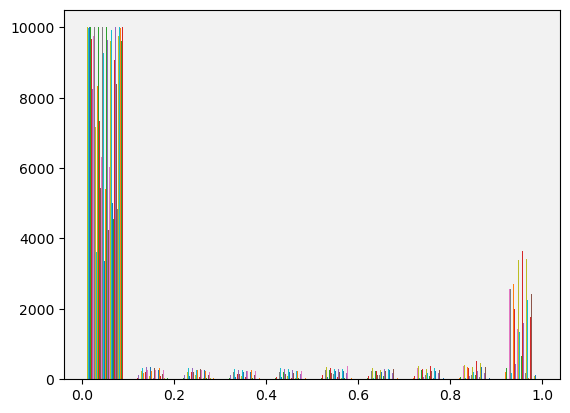

In [11]:
plt.hist(X_test_resize)

In [27]:
dump(clf_rf, './srf_model/'+str(best_depth)+'_rf.joblib') 
for epoch in tqdm( range(args['epochs'])):
    
    # Training
    tree.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_size = data.size()[0]
        data, target = data.to(device), target.to(device)
        tree = tree.to(device)
        # target_onehot = onehot_coding(target, device, args['output_dim'])
        # print(data.shape)
        output = tree.forward(data, is_training_data=True)

        # loss = criterion(output, target.view(-1))
        loss = criterion(output, target)
        # loss += penalty

        
        # torch.autograd.set_detect_anomaly(True)
        loss.backward()
        optimizer.step()

        # Print training status
        if batch_idx % args['log_interval'] == 0:
            pred = torch.argmax(output,1)
            correct = pred.eq(torch.argmax(target,1)).sum()
            # correct = pred.eq(target.view(-1).data).sum()

            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f} |"
                " Correct: {:03d}/{:03d}"
            )
            print(msg.format(epoch, batch_idx, loss, correct, batch_size))
            training_loss_list.append(loss.cpu().data.numpy())

    # Evaluating
    tree.eval()
    correct = 0.
    with torch.no_grad():
        torch.cuda.empty_cache()
        for batch_idx, (data, target) in enumerate(test_loader):

            batch_size = data.size()[0]
            data, target = data.to(device), target.to(device)

            # output = torch.softmax(tree.forward(data),dim=1)
            output = tree.forward(data)
            pred = torch.argmax(output,1)
            correct += pred.eq(torch.argmax(target,1)).sum()

        accuracy = 100.0 * float(correct) / len(test_loader.dataset)

        if accuracy > best_testing_acc:
            best_testing_acc = accuracy
            save_path = './srf_model/'+str(best_depth)+'_srf_'+str(epoch)+'_'+str(accuracy)+'.pth'
            torch.save(tree.state_dict(), save_path)


        msg = (
            "\nEpoch: {:02d} | Testing Accuracy: {}/{} ({:.3f}%) |"
            " Historical Best: {:.3f}%\n"
        )
        print(
            msg.format(
                epoch, correct,
                len(test_loader.dataset),
                accuracy,
                best_testing_acc
            )
        )
        testing_acc_list.append(accuracy)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 00 | Batch: 000 | Loss: 1.78386 | Correct: 061/100
Epoch: 00 | Batch: 100 | Loss: 1.05750 | Correct: 088/100
Epoch: 00 | Batch: 200 | Loss: 0.82245 | Correct: 090/100
Epoch: 00 | Batch: 300 | Loss: 0.74565 | Correct: 087/100
Epoch: 00 | Batch: 400 | Loss: 0.63804 | Correct: 090/100
Epoch: 00 | Batch: 500 | Loss: 0.51669 | Correct: 095/100


  0%|          | 1/500 [05:17<44:00:20, 317.48s/it]


Epoch: 00 | Testing Accuracy: 9344.0/10000 (93.440%) | Historical Best: 94.000%

Epoch: 01 | Batch: 000 | Loss: 0.52330 | Correct: 094/100
Epoch: 01 | Batch: 100 | Loss: 0.53005 | Correct: 092/100
Epoch: 01 | Batch: 200 | Loss: 0.50792 | Correct: 092/100
Epoch: 01 | Batch: 300 | Loss: 0.48825 | Correct: 090/100
Epoch: 01 | Batch: 400 | Loss: 0.47284 | Correct: 089/100
Epoch: 01 | Batch: 500 | Loss: 0.40149 | Correct: 094/100


  0%|          | 2/500 [11:01<46:02:51, 332.87s/it]


Epoch: 01 | Testing Accuracy: 9424.0/10000 (94.240%) | Historical Best: 94.240%

Epoch: 02 | Batch: 000 | Loss: 0.46373 | Correct: 091/100
Epoch: 02 | Batch: 100 | Loss: 0.38738 | Correct: 094/100
Epoch: 02 | Batch: 200 | Loss: 0.46426 | Correct: 095/100
Epoch: 02 | Batch: 300 | Loss: 0.39181 | Correct: 094/100
Epoch: 02 | Batch: 400 | Loss: 0.47447 | Correct: 091/100
Epoch: 02 | Batch: 500 | Loss: 0.35325 | Correct: 097/100


  1%|          | 3/500 [18:05<51:42:04, 374.50s/it]


Epoch: 02 | Testing Accuracy: 9487.0/10000 (94.870%) | Historical Best: 94.870%

Epoch: 03 | Batch: 000 | Loss: 0.49159 | Correct: 090/100
Epoch: 03 | Batch: 100 | Loss: 0.36255 | Correct: 097/100
Epoch: 03 | Batch: 200 | Loss: 0.42821 | Correct: 093/100
Epoch: 03 | Batch: 300 | Loss: 0.36540 | Correct: 093/100
Epoch: 03 | Batch: 400 | Loss: 0.36671 | Correct: 096/100
Epoch: 03 | Batch: 500 | Loss: 0.24580 | Correct: 099/100


  1%|          | 4/500 [25:10<54:22:54, 394.71s/it]


Epoch: 03 | Testing Accuracy: 9522.0/10000 (95.220%) | Historical Best: 95.220%

Epoch: 04 | Batch: 000 | Loss: 0.35250 | Correct: 093/100
Epoch: 04 | Batch: 100 | Loss: 0.27856 | Correct: 098/100
Epoch: 04 | Batch: 200 | Loss: 0.30684 | Correct: 098/100
Epoch: 04 | Batch: 300 | Loss: 0.32624 | Correct: 093/100
Epoch: 04 | Batch: 400 | Loss: 0.28491 | Correct: 095/100
Epoch: 04 | Batch: 500 | Loss: 0.26995 | Correct: 098/100


  1%|          | 5/500 [32:16<55:48:41, 405.90s/it]


Epoch: 04 | Testing Accuracy: 9544.0/10000 (95.440%) | Historical Best: 95.440%

Epoch: 05 | Batch: 000 | Loss: 0.36800 | Correct: 093/100
Epoch: 05 | Batch: 100 | Loss: 0.34508 | Correct: 092/100
Epoch: 05 | Batch: 200 | Loss: 0.35620 | Correct: 094/100
Epoch: 05 | Batch: 300 | Loss: 0.33762 | Correct: 094/100
Epoch: 05 | Batch: 400 | Loss: 0.36486 | Correct: 090/100
Epoch: 05 | Batch: 500 | Loss: 0.28071 | Correct: 096/100


  1%|          | 6/500 [39:22<56:37:40, 412.67s/it]


Epoch: 05 | Testing Accuracy: 9553.0/10000 (95.530%) | Historical Best: 95.530%

Epoch: 06 | Batch: 000 | Loss: 0.23784 | Correct: 099/100
Epoch: 06 | Batch: 100 | Loss: 0.27018 | Correct: 096/100
Epoch: 06 | Batch: 200 | Loss: 0.32248 | Correct: 094/100
Epoch: 06 | Batch: 300 | Loss: 0.27017 | Correct: 096/100
Epoch: 06 | Batch: 400 | Loss: 0.38111 | Correct: 092/100
Epoch: 06 | Batch: 500 | Loss: 0.28928 | Correct: 096/100


  1%|▏         | 7/500 [46:28<57:06:14, 416.99s/it]


Epoch: 06 | Testing Accuracy: 9559.0/10000 (95.590%) | Historical Best: 95.590%

Epoch: 07 | Batch: 000 | Loss: 0.26959 | Correct: 097/100
Epoch: 07 | Batch: 100 | Loss: 0.24593 | Correct: 096/100
Epoch: 07 | Batch: 200 | Loss: 0.32774 | Correct: 096/100
Epoch: 07 | Batch: 300 | Loss: 0.34052 | Correct: 093/100
Epoch: 07 | Batch: 400 | Loss: 0.37261 | Correct: 087/100
Epoch: 07 | Batch: 500 | Loss: 0.30362 | Correct: 096/100


  2%|▏         | 8/500 [53:33<57:21:48, 419.73s/it]


Epoch: 07 | Testing Accuracy: 9565.0/10000 (95.650%) | Historical Best: 95.650%

Epoch: 08 | Batch: 000 | Loss: 0.32609 | Correct: 096/100
Epoch: 08 | Batch: 100 | Loss: 0.31489 | Correct: 095/100
Epoch: 08 | Batch: 200 | Loss: 0.28324 | Correct: 094/100
Epoch: 08 | Batch: 300 | Loss: 0.37855 | Correct: 092/100
Epoch: 08 | Batch: 400 | Loss: 0.32163 | Correct: 091/100
Epoch: 08 | Batch: 500 | Loss: 0.28124 | Correct: 097/100


  2%|▏         | 9/500 [1:00:39<57:30:00, 421.59s/it]


Epoch: 08 | Testing Accuracy: 9569.0/10000 (95.690%) | Historical Best: 95.690%

Epoch: 09 | Batch: 000 | Loss: 0.32301 | Correct: 093/100
Epoch: 09 | Batch: 100 | Loss: 0.19108 | Correct: 098/100
Epoch: 09 | Batch: 200 | Loss: 0.24671 | Correct: 096/100
Epoch: 09 | Batch: 300 | Loss: 0.18370 | Correct: 098/100
Epoch: 09 | Batch: 400 | Loss: 0.30290 | Correct: 093/100
Epoch: 09 | Batch: 500 | Loss: 0.19866 | Correct: 099/100


  2%|▏         | 10/500 [1:07:45<57:33:02, 422.82s/it]


Epoch: 09 | Testing Accuracy: 9578.0/10000 (95.780%) | Historical Best: 95.780%

Epoch: 10 | Batch: 000 | Loss: 0.28064 | Correct: 097/100
Epoch: 10 | Batch: 100 | Loss: 0.19196 | Correct: 099/100
Epoch: 10 | Batch: 200 | Loss: 0.22623 | Correct: 096/100
Epoch: 10 | Batch: 300 | Loss: 0.25273 | Correct: 098/100
Epoch: 10 | Batch: 400 | Loss: 0.22403 | Correct: 096/100
Epoch: 10 | Batch: 500 | Loss: 0.24819 | Correct: 096/100


  2%|▏         | 11/500 [1:14:50<57:33:19, 423.72s/it]


Epoch: 10 | Testing Accuracy: 9576.0/10000 (95.760%) | Historical Best: 95.780%

Epoch: 11 | Batch: 000 | Loss: 0.31411 | Correct: 095/100
Epoch: 11 | Batch: 100 | Loss: 0.27380 | Correct: 092/100
Epoch: 11 | Batch: 200 | Loss: 0.25394 | Correct: 096/100
Epoch: 11 | Batch: 300 | Loss: 0.31534 | Correct: 093/100
Epoch: 11 | Batch: 400 | Loss: 0.26763 | Correct: 096/100
Epoch: 11 | Batch: 500 | Loss: 0.25699 | Correct: 095/100


  2%|▏         | 12/500 [1:21:56<57:31:10, 424.33s/it]


Epoch: 11 | Testing Accuracy: 9581.0/10000 (95.810%) | Historical Best: 95.810%

Epoch: 12 | Batch: 000 | Loss: 0.18553 | Correct: 098/100
Epoch: 12 | Batch: 100 | Loss: 0.20410 | Correct: 098/100
Epoch: 12 | Batch: 200 | Loss: 0.27100 | Correct: 094/100
Epoch: 12 | Batch: 300 | Loss: 0.22822 | Correct: 099/100
Epoch: 12 | Batch: 400 | Loss: 0.26084 | Correct: 096/100
Epoch: 12 | Batch: 500 | Loss: 0.19142 | Correct: 098/100


  3%|▎         | 13/500 [1:29:02<57:27:04, 424.69s/it]


Epoch: 12 | Testing Accuracy: 9589.0/10000 (95.890%) | Historical Best: 95.890%

Epoch: 13 | Batch: 000 | Loss: 0.33429 | Correct: 093/100
Epoch: 13 | Batch: 100 | Loss: 0.23304 | Correct: 096/100
Epoch: 13 | Batch: 200 | Loss: 0.18777 | Correct: 098/100
Epoch: 13 | Batch: 300 | Loss: 0.25180 | Correct: 097/100
Epoch: 13 | Batch: 400 | Loss: 0.24701 | Correct: 098/100
Epoch: 13 | Batch: 500 | Loss: 0.33203 | Correct: 092/100


  3%|▎         | 14/500 [1:36:07<57:22:10, 424.96s/it]


Epoch: 13 | Testing Accuracy: 9581.0/10000 (95.810%) | Historical Best: 95.890%

Epoch: 14 | Batch: 000 | Loss: 0.24254 | Correct: 097/100
Epoch: 14 | Batch: 100 | Loss: 0.23809 | Correct: 096/100
Epoch: 14 | Batch: 200 | Loss: 0.17981 | Correct: 100/100
Epoch: 14 | Batch: 300 | Loss: 0.18948 | Correct: 098/100
Epoch: 14 | Batch: 400 | Loss: 0.27282 | Correct: 092/100
Epoch: 14 | Batch: 500 | Loss: 0.19834 | Correct: 098/100


  3%|▎         | 15/500 [1:43:13<57:16:59, 425.20s/it]


Epoch: 14 | Testing Accuracy: 9591.0/10000 (95.910%) | Historical Best: 95.910%

Epoch: 15 | Batch: 000 | Loss: 0.24835 | Correct: 096/100
Epoch: 15 | Batch: 100 | Loss: 0.25498 | Correct: 094/100
Epoch: 15 | Batch: 200 | Loss: 0.23017 | Correct: 098/100
Epoch: 15 | Batch: 300 | Loss: 0.27095 | Correct: 096/100
Epoch: 15 | Batch: 400 | Loss: 0.25649 | Correct: 096/100
Epoch: 15 | Batch: 500 | Loss: 0.22013 | Correct: 095/100


  3%|▎         | 16/500 [1:50:19<57:11:07, 425.35s/it]


Epoch: 15 | Testing Accuracy: 9582.0/10000 (95.820%) | Historical Best: 95.910%

Epoch: 16 | Batch: 000 | Loss: 0.20298 | Correct: 097/100
Epoch: 16 | Batch: 100 | Loss: 0.22151 | Correct: 095/100
Epoch: 16 | Batch: 200 | Loss: 0.18418 | Correct: 099/100
Epoch: 16 | Batch: 300 | Loss: 0.20073 | Correct: 099/100
Epoch: 16 | Batch: 400 | Loss: 0.27707 | Correct: 097/100
Epoch: 16 | Batch: 500 | Loss: 0.19922 | Correct: 099/100


  3%|▎         | 17/500 [1:57:25<57:05:38, 425.55s/it]


Epoch: 16 | Testing Accuracy: 9593.0/10000 (95.930%) | Historical Best: 95.930%

Epoch: 17 | Batch: 000 | Loss: 0.21548 | Correct: 098/100
Epoch: 17 | Batch: 100 | Loss: 0.20343 | Correct: 096/100
Epoch: 17 | Batch: 200 | Loss: 0.26201 | Correct: 095/100
Epoch: 17 | Batch: 300 | Loss: 0.20361 | Correct: 097/100
Epoch: 17 | Batch: 400 | Loss: 0.19873 | Correct: 097/100
Epoch: 17 | Batch: 500 | Loss: 0.23970 | Correct: 095/100


  4%|▎         | 18/500 [2:04:30<56:59:07, 425.62s/it]


Epoch: 17 | Testing Accuracy: 9594.0/10000 (95.940%) | Historical Best: 95.940%

Epoch: 18 | Batch: 000 | Loss: 0.22481 | Correct: 097/100
Epoch: 18 | Batch: 100 | Loss: 0.22544 | Correct: 095/100
Epoch: 18 | Batch: 200 | Loss: 0.19127 | Correct: 098/100
Epoch: 18 | Batch: 300 | Loss: 0.17521 | Correct: 098/100
Epoch: 18 | Batch: 400 | Loss: 0.17963 | Correct: 099/100
Epoch: 18 | Batch: 500 | Loss: 0.19231 | Correct: 098/100


  4%|▍         | 19/500 [2:11:36<56:52:05, 425.63s/it]


Epoch: 18 | Testing Accuracy: 9591.0/10000 (95.910%) | Historical Best: 95.940%

Epoch: 19 | Batch: 000 | Loss: 0.20280 | Correct: 096/100
Epoch: 19 | Batch: 100 | Loss: 0.22536 | Correct: 096/100
Epoch: 19 | Batch: 200 | Loss: 0.20245 | Correct: 098/100
Epoch: 19 | Batch: 300 | Loss: 0.19764 | Correct: 097/100
Epoch: 19 | Batch: 400 | Loss: 0.21124 | Correct: 098/100
Epoch: 19 | Batch: 500 | Loss: 0.18474 | Correct: 098/100


  4%|▍         | 20/500 [2:18:42<56:44:50, 425.61s/it]


Epoch: 19 | Testing Accuracy: 9589.0/10000 (95.890%) | Historical Best: 95.940%

Epoch: 20 | Batch: 000 | Loss: 0.19568 | Correct: 097/100
Epoch: 20 | Batch: 100 | Loss: 0.23087 | Correct: 095/100
Epoch: 20 | Batch: 200 | Loss: 0.21578 | Correct: 098/100
Epoch: 20 | Batch: 300 | Loss: 0.17690 | Correct: 097/100
Epoch: 20 | Batch: 400 | Loss: 0.25027 | Correct: 095/100
Epoch: 20 | Batch: 500 | Loss: 0.14505 | Correct: 099/100


  4%|▍         | 21/500 [2:25:48<56:38:31, 425.70s/it]


Epoch: 20 | Testing Accuracy: 9592.0/10000 (95.920%) | Historical Best: 95.940%

Epoch: 21 | Batch: 000 | Loss: 0.19834 | Correct: 098/100
Epoch: 21 | Batch: 100 | Loss: 0.20876 | Correct: 097/100
Epoch: 21 | Batch: 200 | Loss: 0.18671 | Correct: 096/100
Epoch: 21 | Batch: 300 | Loss: 0.16308 | Correct: 099/100
Epoch: 21 | Batch: 400 | Loss: 0.21182 | Correct: 096/100
Epoch: 21 | Batch: 500 | Loss: 0.22352 | Correct: 094/100


  4%|▍         | 22/500 [2:32:53<56:31:54, 425.76s/it]


Epoch: 21 | Testing Accuracy: 9602.0/10000 (96.020%) | Historical Best: 96.020%

Epoch: 22 | Batch: 000 | Loss: 0.18179 | Correct: 096/100
Epoch: 22 | Batch: 100 | Loss: 0.22486 | Correct: 096/100
Epoch: 22 | Batch: 200 | Loss: 0.20712 | Correct: 098/100
Epoch: 22 | Batch: 300 | Loss: 0.28296 | Correct: 094/100
Epoch: 22 | Batch: 400 | Loss: 0.18820 | Correct: 097/100
Epoch: 22 | Batch: 500 | Loss: 0.15732 | Correct: 098/100


  5%|▍         | 23/500 [2:40:00<56:25:26, 425.84s/it]


Epoch: 22 | Testing Accuracy: 9594.0/10000 (95.940%) | Historical Best: 96.020%

Epoch: 23 | Batch: 000 | Loss: 0.23334 | Correct: 095/100
Epoch: 23 | Batch: 100 | Loss: 0.16078 | Correct: 098/100
Epoch: 23 | Batch: 200 | Loss: 0.18945 | Correct: 096/100
Epoch: 23 | Batch: 300 | Loss: 0.18809 | Correct: 098/100
Epoch: 23 | Batch: 400 | Loss: 0.25394 | Correct: 095/100
Epoch: 23 | Batch: 500 | Loss: 0.20994 | Correct: 097/100


  5%|▍         | 24/500 [2:47:05<56:18:11, 425.82s/it]


Epoch: 23 | Testing Accuracy: 9600.0/10000 (96.000%) | Historical Best: 96.020%

Epoch: 24 | Batch: 000 | Loss: 0.18127 | Correct: 097/100
Epoch: 24 | Batch: 100 | Loss: 0.21830 | Correct: 095/100
Epoch: 24 | Batch: 200 | Loss: 0.24693 | Correct: 095/100
Epoch: 24 | Batch: 300 | Loss: 0.26426 | Correct: 092/100
Epoch: 24 | Batch: 400 | Loss: 0.20296 | Correct: 097/100
Epoch: 24 | Batch: 500 | Loss: 0.22831 | Correct: 094/100


  5%|▌         | 25/500 [2:54:11<56:10:38, 425.76s/it]


Epoch: 24 | Testing Accuracy: 9597.0/10000 (95.970%) | Historical Best: 96.020%

Epoch: 25 | Batch: 000 | Loss: 0.24704 | Correct: 096/100
Epoch: 25 | Batch: 100 | Loss: 0.19001 | Correct: 097/100
Epoch: 25 | Batch: 200 | Loss: 0.22376 | Correct: 094/100
Epoch: 25 | Batch: 300 | Loss: 0.19892 | Correct: 097/100
Epoch: 25 | Batch: 400 | Loss: 0.23843 | Correct: 097/100
Epoch: 25 | Batch: 500 | Loss: 0.22499 | Correct: 096/100


  5%|▌         | 26/500 [3:01:17<56:03:21, 425.74s/it]


Epoch: 25 | Testing Accuracy: 9600.0/10000 (96.000%) | Historical Best: 96.020%

Epoch: 26 | Batch: 000 | Loss: 0.18074 | Correct: 099/100
Epoch: 26 | Batch: 100 | Loss: 0.26310 | Correct: 093/100
Epoch: 26 | Batch: 200 | Loss: 0.18978 | Correct: 097/100
Epoch: 26 | Batch: 300 | Loss: 0.19755 | Correct: 097/100
Epoch: 26 | Batch: 400 | Loss: 0.22024 | Correct: 093/100
Epoch: 26 | Batch: 500 | Loss: 0.17366 | Correct: 097/100


  5%|▌         | 27/500 [3:08:22<55:56:07, 425.72s/it]


Epoch: 26 | Testing Accuracy: 9597.0/10000 (95.970%) | Historical Best: 96.020%

Epoch: 27 | Batch: 000 | Loss: 0.26337 | Correct: 094/100
Epoch: 27 | Batch: 100 | Loss: 0.20461 | Correct: 099/100
Epoch: 27 | Batch: 200 | Loss: 0.22242 | Correct: 097/100
Epoch: 27 | Batch: 300 | Loss: 0.20497 | Correct: 096/100
Epoch: 27 | Batch: 400 | Loss: 0.24576 | Correct: 096/100
Epoch: 27 | Batch: 500 | Loss: 0.20573 | Correct: 097/100


  6%|▌         | 28/500 [3:15:28<55:49:16, 425.76s/it]


Epoch: 27 | Testing Accuracy: 9602.0/10000 (96.020%) | Historical Best: 96.020%

Epoch: 28 | Batch: 000 | Loss: 0.16952 | Correct: 098/100
Epoch: 28 | Batch: 100 | Loss: 0.17103 | Correct: 098/100
Epoch: 28 | Batch: 200 | Loss: 0.17847 | Correct: 099/100
Epoch: 28 | Batch: 300 | Loss: 0.16762 | Correct: 098/100
Epoch: 28 | Batch: 400 | Loss: 0.24071 | Correct: 097/100
Epoch: 28 | Batch: 500 | Loss: 0.23698 | Correct: 094/100


  6%|▌         | 29/500 [3:22:34<55:41:54, 425.72s/it]


Epoch: 28 | Testing Accuracy: 9590.0/10000 (95.900%) | Historical Best: 96.020%

Epoch: 29 | Batch: 000 | Loss: 0.24162 | Correct: 095/100
Epoch: 29 | Batch: 100 | Loss: 0.19440 | Correct: 097/100
Epoch: 29 | Batch: 200 | Loss: 0.24531 | Correct: 093/100
Epoch: 29 | Batch: 300 | Loss: 0.19512 | Correct: 096/100
Epoch: 29 | Batch: 400 | Loss: 0.22316 | Correct: 096/100
Epoch: 29 | Batch: 500 | Loss: 0.14162 | Correct: 099/100


  6%|▌         | 30/500 [3:29:40<55:35:19, 425.79s/it]


Epoch: 29 | Testing Accuracy: 9593.0/10000 (95.930%) | Historical Best: 96.020%

Epoch: 30 | Batch: 000 | Loss: 0.18379 | Correct: 096/100
Epoch: 30 | Batch: 100 | Loss: 0.21061 | Correct: 097/100
Epoch: 30 | Batch: 200 | Loss: 0.23877 | Correct: 096/100
Epoch: 30 | Batch: 300 | Loss: 0.18313 | Correct: 096/100
Epoch: 30 | Batch: 400 | Loss: 0.24940 | Correct: 095/100
Epoch: 30 | Batch: 500 | Loss: 0.22265 | Correct: 096/100


  6%|▌         | 31/500 [3:36:45<55:27:44, 425.72s/it]


Epoch: 30 | Testing Accuracy: 9588.0/10000 (95.880%) | Historical Best: 96.020%

Epoch: 31 | Batch: 000 | Loss: 0.14502 | Correct: 098/100
Epoch: 31 | Batch: 100 | Loss: 0.17107 | Correct: 097/100
Epoch: 31 | Batch: 200 | Loss: 0.21439 | Correct: 095/100
Epoch: 31 | Batch: 300 | Loss: 0.22334 | Correct: 096/100
Epoch: 31 | Batch: 400 | Loss: 0.19117 | Correct: 099/100
Epoch: 31 | Batch: 500 | Loss: 0.21520 | Correct: 095/100


  6%|▋         | 32/500 [3:43:51<55:20:07, 425.66s/it]


Epoch: 31 | Testing Accuracy: 9588.0/10000 (95.880%) | Historical Best: 96.020%

Epoch: 32 | Batch: 000 | Loss: 0.18931 | Correct: 097/100
Epoch: 32 | Batch: 100 | Loss: 0.21462 | Correct: 096/100
Epoch: 32 | Batch: 200 | Loss: 0.21076 | Correct: 093/100
Epoch: 32 | Batch: 300 | Loss: 0.28339 | Correct: 091/100
Epoch: 32 | Batch: 400 | Loss: 0.16232 | Correct: 097/100
Epoch: 32 | Batch: 500 | Loss: 0.14669 | Correct: 099/100


  7%|▋         | 33/500 [3:50:57<55:13:15, 425.69s/it]


Epoch: 32 | Testing Accuracy: 9583.0/10000 (95.830%) | Historical Best: 96.020%

Epoch: 33 | Batch: 000 | Loss: 0.17067 | Correct: 098/100
Epoch: 33 | Batch: 100 | Loss: 0.26930 | Correct: 092/100
Epoch: 33 | Batch: 200 | Loss: 0.17538 | Correct: 098/100
Epoch: 33 | Batch: 300 | Loss: 0.22932 | Correct: 096/100
Epoch: 33 | Batch: 400 | Loss: 0.15824 | Correct: 098/100
Epoch: 33 | Batch: 500 | Loss: 0.19862 | Correct: 097/100


  7%|▋         | 34/500 [3:58:02<55:06:16, 425.70s/it]


Epoch: 33 | Testing Accuracy: 9580.0/10000 (95.800%) | Historical Best: 96.020%

Epoch: 34 | Batch: 000 | Loss: 0.18107 | Correct: 096/100
Epoch: 34 | Batch: 100 | Loss: 0.21322 | Correct: 097/100
Epoch: 34 | Batch: 200 | Loss: 0.16206 | Correct: 099/100
Epoch: 34 | Batch: 300 | Loss: 0.13975 | Correct: 100/100
Epoch: 34 | Batch: 400 | Loss: 0.17848 | Correct: 098/100
Epoch: 34 | Batch: 500 | Loss: 0.25281 | Correct: 094/100


  7%|▋         | 35/500 [4:05:08<54:59:24, 425.73s/it]


Epoch: 34 | Testing Accuracy: 9601.0/10000 (96.010%) | Historical Best: 96.020%

Epoch: 35 | Batch: 000 | Loss: 0.17820 | Correct: 097/100
Epoch: 35 | Batch: 100 | Loss: 0.15172 | Correct: 098/100
Epoch: 35 | Batch: 200 | Loss: 0.13226 | Correct: 098/100
Epoch: 35 | Batch: 300 | Loss: 0.20756 | Correct: 096/100
Epoch: 35 | Batch: 400 | Loss: 0.17894 | Correct: 096/100
Epoch: 35 | Batch: 500 | Loss: 0.16592 | Correct: 097/100


  7%|▋         | 36/500 [4:12:14<54:52:00, 425.69s/it]


Epoch: 35 | Testing Accuracy: 9605.0/10000 (96.050%) | Historical Best: 96.050%

Epoch: 36 | Batch: 000 | Loss: 0.14462 | Correct: 099/100
Epoch: 36 | Batch: 100 | Loss: 0.17620 | Correct: 096/100
Epoch: 36 | Batch: 200 | Loss: 0.21412 | Correct: 096/100
Epoch: 36 | Batch: 300 | Loss: 0.23113 | Correct: 095/100
Epoch: 36 | Batch: 400 | Loss: 0.22937 | Correct: 094/100
Epoch: 36 | Batch: 500 | Loss: 0.17962 | Correct: 097/100


  7%|▋         | 37/500 [4:19:19<54:45:11, 425.73s/it]


Epoch: 36 | Testing Accuracy: 9597.0/10000 (95.970%) | Historical Best: 96.050%

Epoch: 37 | Batch: 000 | Loss: 0.16424 | Correct: 097/100
Epoch: 37 | Batch: 100 | Loss: 0.22837 | Correct: 098/100
Epoch: 37 | Batch: 200 | Loss: 0.17976 | Correct: 097/100
Epoch: 37 | Batch: 300 | Loss: 0.17399 | Correct: 096/100
Epoch: 37 | Batch: 400 | Loss: 0.23965 | Correct: 095/100
Epoch: 37 | Batch: 500 | Loss: 0.19515 | Correct: 098/100


  8%|▊         | 38/500 [4:26:25<54:37:45, 425.68s/it]


Epoch: 37 | Testing Accuracy: 9600.0/10000 (96.000%) | Historical Best: 96.050%

Epoch: 38 | Batch: 000 | Loss: 0.14173 | Correct: 100/100
Epoch: 38 | Batch: 100 | Loss: 0.13844 | Correct: 098/100
Epoch: 38 | Batch: 200 | Loss: 0.18902 | Correct: 096/100
Epoch: 38 | Batch: 300 | Loss: 0.15547 | Correct: 097/100
Epoch: 38 | Batch: 400 | Loss: 0.15697 | Correct: 097/100
Epoch: 38 | Batch: 500 | Loss: 0.17079 | Correct: 096/100


  8%|▊         | 39/500 [4:33:31<54:30:34, 425.67s/it]


Epoch: 38 | Testing Accuracy: 9600.0/10000 (96.000%) | Historical Best: 96.050%

Epoch: 39 | Batch: 000 | Loss: 0.19902 | Correct: 097/100
Epoch: 39 | Batch: 100 | Loss: 0.22213 | Correct: 097/100
Epoch: 39 | Batch: 200 | Loss: 0.13566 | Correct: 098/100
Epoch: 39 | Batch: 300 | Loss: 0.24198 | Correct: 095/100
Epoch: 39 | Batch: 400 | Loss: 0.19193 | Correct: 096/100
Epoch: 39 | Batch: 500 | Loss: 0.22288 | Correct: 095/100


  8%|▊         | 40/500 [4:40:36<54:23:44, 425.70s/it]


Epoch: 39 | Testing Accuracy: 9599.0/10000 (95.990%) | Historical Best: 96.050%

Epoch: 40 | Batch: 000 | Loss: 0.20738 | Correct: 094/100
Epoch: 40 | Batch: 100 | Loss: 0.21267 | Correct: 095/100
Epoch: 40 | Batch: 200 | Loss: 0.24051 | Correct: 093/100
Epoch: 40 | Batch: 300 | Loss: 0.15172 | Correct: 098/100
Epoch: 40 | Batch: 400 | Loss: 0.21184 | Correct: 096/100
Epoch: 40 | Batch: 500 | Loss: 0.25090 | Correct: 095/100


  8%|▊         | 41/500 [4:47:42<54:16:10, 425.64s/it]


Epoch: 40 | Testing Accuracy: 9594.0/10000 (95.940%) | Historical Best: 96.050%

Epoch: 41 | Batch: 000 | Loss: 0.26020 | Correct: 094/100
Epoch: 41 | Batch: 100 | Loss: 0.18299 | Correct: 099/100
Epoch: 41 | Batch: 200 | Loss: 0.19806 | Correct: 096/100
Epoch: 41 | Batch: 300 | Loss: 0.18044 | Correct: 098/100
Epoch: 41 | Batch: 400 | Loss: 0.21284 | Correct: 095/100
Epoch: 41 | Batch: 500 | Loss: 0.19489 | Correct: 097/100


  8%|▊         | 42/500 [4:54:48<54:09:31, 425.70s/it]


Epoch: 41 | Testing Accuracy: 9589.0/10000 (95.890%) | Historical Best: 96.050%

Epoch: 42 | Batch: 000 | Loss: 0.22336 | Correct: 095/100
Epoch: 42 | Batch: 100 | Loss: 0.20528 | Correct: 096/100
Epoch: 42 | Batch: 200 | Loss: 0.18910 | Correct: 097/100
Epoch: 42 | Batch: 300 | Loss: 0.17050 | Correct: 099/100
Epoch: 42 | Batch: 400 | Loss: 0.17738 | Correct: 099/100
Epoch: 42 | Batch: 500 | Loss: 0.19361 | Correct: 096/100


  9%|▊         | 43/500 [5:01:53<54:02:02, 425.65s/it]


Epoch: 42 | Testing Accuracy: 9600.0/10000 (96.000%) | Historical Best: 96.050%

Epoch: 43 | Batch: 000 | Loss: 0.30954 | Correct: 094/100
Epoch: 43 | Batch: 100 | Loss: 0.15986 | Correct: 097/100
Epoch: 43 | Batch: 200 | Loss: 0.18399 | Correct: 097/100
Epoch: 43 | Batch: 300 | Loss: 0.19625 | Correct: 094/100
Epoch: 43 | Batch: 400 | Loss: 0.21834 | Correct: 096/100
Epoch: 43 | Batch: 500 | Loss: 0.17003 | Correct: 098/100


  9%|▉         | 44/500 [5:08:59<53:55:40, 425.75s/it]


Epoch: 43 | Testing Accuracy: 9592.0/10000 (95.920%) | Historical Best: 96.050%

Epoch: 44 | Batch: 000 | Loss: 0.17478 | Correct: 097/100
Epoch: 44 | Batch: 100 | Loss: 0.15998 | Correct: 097/100
Epoch: 44 | Batch: 200 | Loss: 0.25689 | Correct: 093/100
Epoch: 44 | Batch: 300 | Loss: 0.17263 | Correct: 097/100
Epoch: 44 | Batch: 400 | Loss: 0.14353 | Correct: 099/100
Epoch: 44 | Batch: 500 | Loss: 0.25534 | Correct: 094/100


  9%|▉         | 45/500 [5:16:05<53:48:47, 425.77s/it]


Epoch: 44 | Testing Accuracy: 9595.0/10000 (95.950%) | Historical Best: 96.050%

Epoch: 45 | Batch: 000 | Loss: 0.19853 | Correct: 094/100
Epoch: 45 | Batch: 100 | Loss: 0.20914 | Correct: 094/100
Epoch: 45 | Batch: 200 | Loss: 0.16577 | Correct: 097/100
Epoch: 45 | Batch: 300 | Loss: 0.21379 | Correct: 094/100
Epoch: 45 | Batch: 400 | Loss: 0.20704 | Correct: 095/100
Epoch: 45 | Batch: 500 | Loss: 0.19790 | Correct: 095/100


  9%|▉         | 46/500 [5:23:11<53:42:34, 425.89s/it]


Epoch: 45 | Testing Accuracy: 9594.0/10000 (95.940%) | Historical Best: 96.050%

Epoch: 46 | Batch: 000 | Loss: 0.14367 | Correct: 100/100
Epoch: 46 | Batch: 100 | Loss: 0.18107 | Correct: 097/100
Epoch: 46 | Batch: 200 | Loss: 0.20113 | Correct: 094/100
Epoch: 46 | Batch: 300 | Loss: 0.13028 | Correct: 098/100
Epoch: 46 | Batch: 400 | Loss: 0.20739 | Correct: 095/100
Epoch: 46 | Batch: 500 | Loss: 0.26362 | Correct: 094/100


  9%|▉         | 47/500 [5:30:17<53:34:40, 425.79s/it]


Epoch: 46 | Testing Accuracy: 9590.0/10000 (95.900%) | Historical Best: 96.050%

Epoch: 47 | Batch: 000 | Loss: 0.23034 | Correct: 094/100
Epoch: 47 | Batch: 100 | Loss: 0.16251 | Correct: 096/100
Epoch: 47 | Batch: 200 | Loss: 0.18159 | Correct: 099/100
Epoch: 47 | Batch: 300 | Loss: 0.19088 | Correct: 094/100
Epoch: 47 | Batch: 400 | Loss: 0.15096 | Correct: 099/100
Epoch: 47 | Batch: 500 | Loss: 0.15100 | Correct: 099/100


 10%|▉         | 48/500 [5:37:23<53:27:40, 425.80s/it]


Epoch: 47 | Testing Accuracy: 9601.0/10000 (96.010%) | Historical Best: 96.050%

Epoch: 48 | Batch: 000 | Loss: 0.16121 | Correct: 098/100
Epoch: 48 | Batch: 100 | Loss: 0.23974 | Correct: 093/100
Epoch: 48 | Batch: 200 | Loss: 0.18131 | Correct: 096/100
Epoch: 48 | Batch: 300 | Loss: 0.22564 | Correct: 093/100
Epoch: 48 | Batch: 400 | Loss: 0.19812 | Correct: 093/100
Epoch: 48 | Batch: 500 | Loss: 0.14559 | Correct: 099/100


 10%|▉         | 49/500 [5:44:28<53:20:05, 425.73s/it]


Epoch: 48 | Testing Accuracy: 9599.0/10000 (95.990%) | Historical Best: 96.050%

Epoch: 49 | Batch: 000 | Loss: 0.14379 | Correct: 097/100
Epoch: 49 | Batch: 100 | Loss: 0.22615 | Correct: 095/100
Epoch: 49 | Batch: 200 | Loss: 0.21068 | Correct: 095/100
Epoch: 49 | Batch: 300 | Loss: 0.19410 | Correct: 097/100
Epoch: 49 | Batch: 400 | Loss: 0.18222 | Correct: 097/100
Epoch: 49 | Batch: 500 | Loss: 0.15777 | Correct: 098/100


 10%|█         | 50/500 [5:51:34<53:13:07, 425.75s/it]


Epoch: 49 | Testing Accuracy: 9598.0/10000 (95.980%) | Historical Best: 96.050%

Epoch: 50 | Batch: 000 | Loss: 0.18844 | Correct: 096/100
Epoch: 50 | Batch: 100 | Loss: 0.15954 | Correct: 097/100
Epoch: 50 | Batch: 200 | Loss: 0.18150 | Correct: 096/100
Epoch: 50 | Batch: 300 | Loss: 0.18964 | Correct: 095/100
Epoch: 50 | Batch: 400 | Loss: 0.13659 | Correct: 099/100
Epoch: 50 | Batch: 500 | Loss: 0.25622 | Correct: 093/100


 10%|█         | 51/500 [5:58:40<53:05:51, 425.73s/it]


Epoch: 50 | Testing Accuracy: 9596.0/10000 (95.960%) | Historical Best: 96.050%

Epoch: 51 | Batch: 000 | Loss: 0.21440 | Correct: 092/100
Epoch: 51 | Batch: 100 | Loss: 0.14617 | Correct: 098/100
Epoch: 51 | Batch: 200 | Loss: 0.18527 | Correct: 096/100
Epoch: 51 | Batch: 300 | Loss: 0.17304 | Correct: 098/100
Epoch: 51 | Batch: 400 | Loss: 0.15150 | Correct: 099/100
Epoch: 51 | Batch: 500 | Loss: 0.16332 | Correct: 096/100


 10%|█         | 52/500 [6:05:46<52:58:52, 425.74s/it]


Epoch: 51 | Testing Accuracy: 9599.0/10000 (95.990%) | Historical Best: 96.050%

Epoch: 52 | Batch: 000 | Loss: 0.28455 | Correct: 093/100
Epoch: 52 | Batch: 100 | Loss: 0.22799 | Correct: 095/100
Epoch: 52 | Batch: 200 | Loss: 0.24868 | Correct: 096/100
Epoch: 52 | Batch: 300 | Loss: 0.19787 | Correct: 096/100
Epoch: 52 | Batch: 400 | Loss: 0.19544 | Correct: 097/100
Epoch: 52 | Batch: 500 | Loss: 0.17768 | Correct: 095/100


 11%|█         | 53/500 [6:12:51<52:51:39, 425.73s/it]


Epoch: 52 | Testing Accuracy: 9588.0/10000 (95.880%) | Historical Best: 96.050%

Epoch: 53 | Batch: 000 | Loss: 0.26453 | Correct: 093/100
Epoch: 53 | Batch: 100 | Loss: 0.22920 | Correct: 094/100
Epoch: 53 | Batch: 200 | Loss: 0.15503 | Correct: 097/100
Epoch: 53 | Batch: 300 | Loss: 0.15780 | Correct: 096/100
Epoch: 53 | Batch: 400 | Loss: 0.12837 | Correct: 099/100
Epoch: 53 | Batch: 500 | Loss: 0.17796 | Correct: 097/100


 11%|█         | 54/500 [6:19:57<52:44:22, 425.70s/it]


Epoch: 53 | Testing Accuracy: 9584.0/10000 (95.840%) | Historical Best: 96.050%

Epoch: 54 | Batch: 000 | Loss: 0.16394 | Correct: 100/100
Epoch: 54 | Batch: 100 | Loss: 0.21988 | Correct: 096/100
Epoch: 54 | Batch: 200 | Loss: 0.20531 | Correct: 095/100
Epoch: 54 | Batch: 300 | Loss: 0.16742 | Correct: 096/100
Epoch: 54 | Batch: 400 | Loss: 0.19022 | Correct: 097/100
Epoch: 54 | Batch: 500 | Loss: 0.17682 | Correct: 098/100


 11%|█         | 55/500 [6:27:03<52:37:25, 425.72s/it]


Epoch: 54 | Testing Accuracy: 9591.0/10000 (95.910%) | Historical Best: 96.050%

Epoch: 55 | Batch: 000 | Loss: 0.27003 | Correct: 094/100
Epoch: 55 | Batch: 100 | Loss: 0.20222 | Correct: 094/100
Epoch: 55 | Batch: 200 | Loss: 0.18954 | Correct: 095/100
Epoch: 55 | Batch: 300 | Loss: 0.17008 | Correct: 097/100
Epoch: 55 | Batch: 400 | Loss: 0.15426 | Correct: 097/100
Epoch: 55 | Batch: 500 | Loss: 0.17982 | Correct: 098/100


 11%|█         | 56/500 [6:34:08<52:30:38, 425.76s/it]


Epoch: 55 | Testing Accuracy: 9588.0/10000 (95.880%) | Historical Best: 96.050%

Epoch: 56 | Batch: 000 | Loss: 0.13827 | Correct: 098/100
Epoch: 56 | Batch: 100 | Loss: 0.26338 | Correct: 092/100
Epoch: 56 | Batch: 200 | Loss: 0.23484 | Correct: 096/100
Epoch: 56 | Batch: 300 | Loss: 0.26367 | Correct: 092/100
Epoch: 56 | Batch: 400 | Loss: 0.24192 | Correct: 093/100
Epoch: 56 | Batch: 500 | Loss: 0.20550 | Correct: 097/100


 11%|█▏        | 57/500 [6:41:14<52:23:44, 425.79s/it]


Epoch: 56 | Testing Accuracy: 9579.0/10000 (95.790%) | Historical Best: 96.050%

Epoch: 57 | Batch: 000 | Loss: 0.16518 | Correct: 099/100
Epoch: 57 | Batch: 100 | Loss: 0.17730 | Correct: 097/100
Epoch: 57 | Batch: 200 | Loss: 0.20141 | Correct: 095/100
Epoch: 57 | Batch: 300 | Loss: 0.24214 | Correct: 092/100
Epoch: 57 | Batch: 400 | Loss: 0.15787 | Correct: 097/100
Epoch: 57 | Batch: 500 | Loss: 0.16380 | Correct: 097/100


 12%|█▏        | 58/500 [6:48:20<52:17:09, 425.86s/it]


Epoch: 57 | Testing Accuracy: 9584.0/10000 (95.840%) | Historical Best: 96.050%

Epoch: 58 | Batch: 000 | Loss: 0.26169 | Correct: 092/100
Epoch: 58 | Batch: 100 | Loss: 0.15438 | Correct: 098/100
Epoch: 58 | Batch: 200 | Loss: 0.20675 | Correct: 097/100
Epoch: 58 | Batch: 300 | Loss: 0.16410 | Correct: 097/100
Epoch: 58 | Batch: 400 | Loss: 0.14642 | Correct: 098/100
Epoch: 58 | Batch: 500 | Loss: 0.12961 | Correct: 098/100


 12%|█▏        | 59/500 [6:55:26<52:09:50, 425.83s/it]


Epoch: 58 | Testing Accuracy: 9581.0/10000 (95.810%) | Historical Best: 96.050%

Epoch: 59 | Batch: 000 | Loss: 0.26992 | Correct: 095/100
Epoch: 59 | Batch: 100 | Loss: 0.22749 | Correct: 095/100
Epoch: 59 | Batch: 200 | Loss: 0.23206 | Correct: 093/100
Epoch: 59 | Batch: 300 | Loss: 0.22725 | Correct: 096/100
Epoch: 59 | Batch: 400 | Loss: 0.16689 | Correct: 098/100
Epoch: 59 | Batch: 500 | Loss: 0.18434 | Correct: 098/100


 12%|█▏        | 60/500 [7:02:32<52:02:58, 425.86s/it]


Epoch: 59 | Testing Accuracy: 9588.0/10000 (95.880%) | Historical Best: 96.050%

Epoch: 60 | Batch: 000 | Loss: 0.17013 | Correct: 096/100
Epoch: 60 | Batch: 100 | Loss: 0.22076 | Correct: 095/100
Epoch: 60 | Batch: 200 | Loss: 0.19117 | Correct: 095/100
Epoch: 60 | Batch: 300 | Loss: 0.17231 | Correct: 097/100
Epoch: 60 | Batch: 400 | Loss: 0.22706 | Correct: 094/100
Epoch: 60 | Batch: 500 | Loss: 0.19700 | Correct: 097/100


 12%|█▏        | 61/500 [7:09:38<51:55:49, 425.85s/it]


Epoch: 60 | Testing Accuracy: 9583.0/10000 (95.830%) | Historical Best: 96.050%

Epoch: 61 | Batch: 000 | Loss: 0.24982 | Correct: 095/100
Epoch: 61 | Batch: 100 | Loss: 0.18031 | Correct: 095/100
Epoch: 61 | Batch: 200 | Loss: 0.26443 | Correct: 096/100
Epoch: 61 | Batch: 300 | Loss: 0.21441 | Correct: 096/100
Epoch: 61 | Batch: 400 | Loss: 0.24796 | Correct: 095/100
Epoch: 61 | Batch: 500 | Loss: 0.21357 | Correct: 095/100


 12%|█▏        | 62/500 [7:16:44<51:48:23, 425.81s/it]


Epoch: 61 | Testing Accuracy: 9587.0/10000 (95.870%) | Historical Best: 96.050%

Epoch: 62 | Batch: 000 | Loss: 0.14925 | Correct: 100/100
Epoch: 62 | Batch: 100 | Loss: 0.14447 | Correct: 098/100
Epoch: 62 | Batch: 200 | Loss: 0.22050 | Correct: 095/100
Epoch: 62 | Batch: 300 | Loss: 0.14487 | Correct: 097/100
Epoch: 62 | Batch: 400 | Loss: 0.13769 | Correct: 099/100
Epoch: 62 | Batch: 500 | Loss: 0.16312 | Correct: 098/100


 13%|█▎        | 63/500 [7:23:49<51:41:09, 425.79s/it]


Epoch: 62 | Testing Accuracy: 9593.0/10000 (95.930%) | Historical Best: 96.050%

Epoch: 63 | Batch: 000 | Loss: 0.17473 | Correct: 098/100
Epoch: 63 | Batch: 100 | Loss: 0.21673 | Correct: 096/100
Epoch: 63 | Batch: 200 | Loss: 0.18903 | Correct: 096/100
Epoch: 63 | Batch: 300 | Loss: 0.18902 | Correct: 096/100
Epoch: 63 | Batch: 400 | Loss: 0.22812 | Correct: 095/100
Epoch: 63 | Batch: 500 | Loss: 0.20698 | Correct: 095/100


 13%|█▎        | 64/500 [7:30:55<51:33:47, 425.75s/it]


Epoch: 63 | Testing Accuracy: 9582.0/10000 (95.820%) | Historical Best: 96.050%

Epoch: 64 | Batch: 000 | Loss: 0.17039 | Correct: 098/100
Epoch: 64 | Batch: 100 | Loss: 0.24127 | Correct: 094/100
Epoch: 64 | Batch: 200 | Loss: 0.22513 | Correct: 096/100
Epoch: 64 | Batch: 300 | Loss: 0.19526 | Correct: 097/100
Epoch: 64 | Batch: 400 | Loss: 0.20449 | Correct: 096/100
Epoch: 64 | Batch: 500 | Loss: 0.25011 | Correct: 096/100


 13%|█▎        | 65/500 [7:38:01<51:26:30, 425.73s/it]


Epoch: 64 | Testing Accuracy: 9586.0/10000 (95.860%) | Historical Best: 96.050%

Epoch: 65 | Batch: 000 | Loss: 0.16107 | Correct: 096/100
Epoch: 65 | Batch: 100 | Loss: 0.26054 | Correct: 093/100
Epoch: 65 | Batch: 200 | Loss: 0.24786 | Correct: 093/100
Epoch: 65 | Batch: 300 | Loss: 0.17590 | Correct: 098/100
Epoch: 65 | Batch: 400 | Loss: 0.20596 | Correct: 096/100
Epoch: 65 | Batch: 500 | Loss: 0.21682 | Correct: 095/100


 13%|█▎        | 66/500 [7:45:06<51:19:37, 425.75s/it]


Epoch: 65 | Testing Accuracy: 9574.0/10000 (95.740%) | Historical Best: 96.050%

Epoch: 66 | Batch: 000 | Loss: 0.25173 | Correct: 094/100
Epoch: 66 | Batch: 100 | Loss: 0.23732 | Correct: 095/100
Epoch: 66 | Batch: 200 | Loss: 0.17120 | Correct: 095/100
Epoch: 66 | Batch: 300 | Loss: 0.20627 | Correct: 095/100
Epoch: 66 | Batch: 400 | Loss: 0.17465 | Correct: 098/100
Epoch: 66 | Batch: 500 | Loss: 0.19774 | Correct: 095/100


 13%|█▎        | 67/500 [7:52:12<51:12:07, 425.70s/it]


Epoch: 66 | Testing Accuracy: 9577.0/10000 (95.770%) | Historical Best: 96.050%

Epoch: 67 | Batch: 000 | Loss: 0.20629 | Correct: 097/100
Epoch: 67 | Batch: 100 | Loss: 0.15103 | Correct: 098/100
Epoch: 67 | Batch: 200 | Loss: 0.16587 | Correct: 098/100
Epoch: 67 | Batch: 300 | Loss: 0.13660 | Correct: 099/100
Epoch: 67 | Batch: 400 | Loss: 0.21315 | Correct: 097/100


In [22]:
save_path = './srf_model/'+str(best_depth)+'_srf_'+str(accuracy)+'.pth'
torch.save(tree.state_dict(), save_path)


In [28]:
save_path = './srf_model/'+str(best_depth)+'_sdt_'+str(accuracy)+'.pth'

dump(clf, './srf_model/'+str(best_depth)+'_dt.joblib') 
torch.save(tree.state_dict(), save_path)


In [ ]:
clf_new = load('./sdt_model/'+str(best_depth)+'clf.joblib') 
load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
load_tree.load_state_dict(torch.load(save_path))
load_tree.eval()

In [104]:
X_test_noise = X_test_resize.copy()
root_feature = clf.tree_.feature[0]
X_test_noise[:,root_feature] = np.random.random(X_test_noise[:,root_feature].shape)




test_loader_noise = torch.utils.data.DataLoader(
        Mnist_dataset(X_train_resize,
                        X_test_noise,
                        Y_train,
                        Y_test,
                        train_flag=0),
        batch_size=100,
        shuffle=False,
    )

In [135]:

tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = load_tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

91.26


In [106]:

val_preds_baseline = clf.predict(X_test_noise)
acc_baseline_val = acc(val_preds_baseline, y_test)
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

Validation accuracy for our baseline (using all pixel features) under noise: 74.0%


In [36]:
thres_mean = torch.mean(tree.node_threshold.data)
thres_std = torch.std(tree.node_threshold.data)

tensor(0.1406)

(array([3.4860e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00,
        2.4000e+01, 3.6000e+01, 1.2900e+02, 3.1140e+03, 1.0183e+04,
        1.2940e+04, 1.1297e+04, 2.4227e+04, 3.4320e+03, 1.9960e+03,
        7.3800e+02, 9.0000e+01, 1.3000e+01, 3.0000e+00, 6.0000e+00]),
 array([-2.09998197, -1.88952712, -1.67907226, -1.46861741, -1.25816256,
        -1.0477077 , -0.83725285, -0.626798  , -0.41634314, -0.20588829,
         0.00456656,  0.21502142,  0.42547627,  0.63593112,  0.84638597,
         1.05684083,  1.26729568,  1.47775053,  1.68820539,  1.89866024,
         2.10911509]),
 <BarContainer object of 20 artists>)

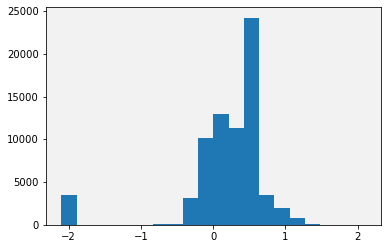

In [132]:
plt.hist(tree.node_threshold.data.reshape(1,-1),20)

In [120]:
tree.node_threshold.data = load_tree.node_threshold.data + torch.tensor(np.random.random(tree.node_threshold.data.shape)*0.2-0.1)

In [121]:
new_clf = DecisionTreeClassifier(max_depth=best_depth)
new_clf.tree_ = clf.tree_

In [122]:
from copy import deepcopy
new_clf = deepcopy(clf)

(array([3586.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,  866.,  536.,  455.,  538.,  285.,
         291.,  614.]),
 array([-2.        , -1.85009804, -1.70019608, -1.55029412, -1.40039216,
        -1.2504902 , -1.10058824, -0.95068627, -0.80078431, -0.65088235,
        -0.50098039, -0.35107843, -0.20117647, -0.05127451,  0.09862745,
         0.24852941,  0.39843137,  0.54833333,  0.69823529,  0.84813726,
         0.99803922]),
 <BarContainer object of 20 artists>)

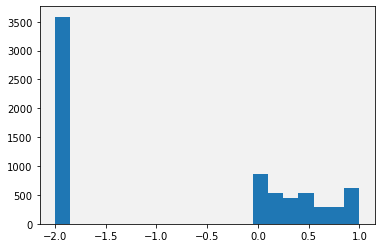

In [133]:
plt.hist(clf.tree_.threshold,20)

In [53]:
new_clf.tree_.threshold.data.shape

(6465,)

In [124]:
new_clf.tree_.threshold[:] = clf.tree_.threshold[:] + np.random.random(clf.tree_.threshold[:].shape)*0.2-0.1

In [125]:
val_preds_baseline = new_clf.predict(X_test_resize)
acc_baseline_val = acc(val_preds_baseline, y_test)
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

Validation accuracy for our baseline (using all pixel features) under noise: 37.26%


In [129]:
val_preds_baseline = new_clf.predict(X_test_noise)
acc_baseline_val = acc(val_preds_baseline, y_test)
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

Validation accuracy for our baseline (using all pixel features) under noise: 35.03%


In [128]:
tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader_noise):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

88.89


(array([57.,  2.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([2.39124615e-29, 2.65910430e-02, 5.31820860e-02, 7.97731290e-02,
        1.06364172e-01, 1.32955215e-01, 1.59546258e-01, 1.86137301e-01,
        2.12728344e-01, 2.39319387e-01, 2.65910430e-01]),
 <BarContainer object of 10 artists>)

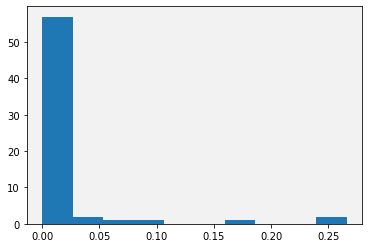

In [ ]:
plt.hist(products[1,:])

In [ ]:
products[np.arange(10000),np.argsort(products[:,:],1)[:,-1]]

array([0.76756538, 0.26591043, 0.63942629, ..., 0.46874392, 0.551196  ,
       0.42305356])

(array([ 114.,  601., 1144., 1334., 1150., 1034., 2006., 1514., 1035.,
          68.]),
 array([0.13263588, 0.21174084, 0.29084581, 0.36995077, 0.44905574,
        0.5281607 , 0.60726566, 0.68637063, 0.76547559, 0.84458055,
        0.92368552]),
 <BarContainer object of 10 artists>)

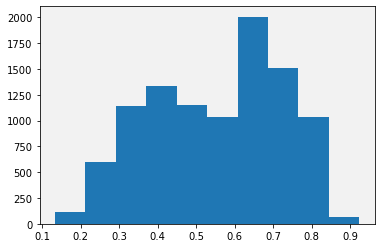

In [ ]:
plt.hist(np.max(products,1))

In [ ]:
_mu = tree._forward(data)

In [ ]:
_mu

tensor([[0.3386, 0.2929, 0.3329,  ..., 0.3041, 0.2554, 0.2673],
        [0.3213, 0.2730, 0.2849,  ..., 0.3193, 0.3248, 0.3227],
        [0.3877, 0.3433, 0.3294,  ..., 0.2076, 0.2978, 0.2971],
        ...,
        [0.3469, 0.3027, 0.3060,  ..., 0.3246, 0.3007, 0.3511],
        [0.3990, 0.2414, 0.3346,  ..., 0.3070, 0.2976, 0.3741],
        [0.2997, 0.2490, 0.2828,  ..., 0.3512, 0.3851, 0.4081]],
       grad_fn=<IndexBackward>)

In [ ]:
torch.max(_mu,1).

torch.return_types.max(
values=tensor([0.7676, 0.2659, 0.6394,  ..., 0.4687, 0.5512, 0.4231],
       dtype=torch.float64, grad_fn=<MaxBackward0>),
indices=tensor([ 0, 23, 16,  ..., 59, 58, 55]))

In [ ]:
target[10]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

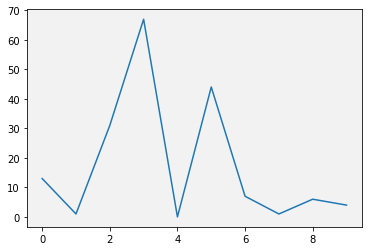

In [ ]:
plt.plot(tree.leaf_nodes[10].detach().numpy())

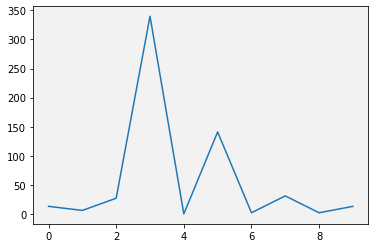

In [ ]:
plt.plot(tree.leaf_nodes[8].detach().numpy())

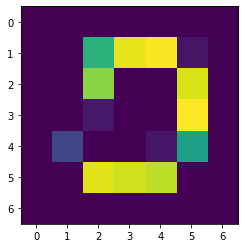

In [ ]:
plt.imshow(data[10,:].reshape(7,7))

In [ ]:
X_train_resize.shape

(60000, 49)

In [ ]:
clf.tree_.feature

array([350, 568, 430, ..., 405,  -2,  -2], dtype=int64)